# Script to analyze nsna data by groups
Load and analyze the processed_data.npy file

## Libraries

In [1]:
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib.pyplot as plt

## Functions

In [2]:
def fit_and_plot_variance_with_background_binned_step(I, Var, region_label, I_step=1, Var_step=1):
    """
    Bin the data with specified steps, fit the variance model with background signal, and plot the results.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        region_label (str): Label for the region being analyzed.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        dict: Fitted parameters {i, N, B} and their uncertainties.
    """
    # Bin the data with specified steps
    binned_I, binned_Var = bin_data_with_step(I, Var, I_step, Var_step)
    if (len(binned_I) < 5):
        return
    if (len(binned_Var) < 5):
        return


    #######

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(binned_I, binned_Var)

    # Initial guess and constraints
    p0 = [slope, np.mean(binned_I), np.min(binned_I)]
    bounds = ([0, 0, -np.inf], [np.inf, np.inf, np.inf])  # Non-negative a and b

    # Clean and preprocess data
    valid_mask = (binned_I > 0) & (binned_Var > 0)
    binned_I = binned_I[valid_mask]
    binned_Var = binned_Var[valid_mask]

    # Fit the model with increased maxfev
    popt, pcov = curve_fit(
        variance_model_with_background, 
        binned_I, 
        binned_Var, 
        p0=p0, 
        bounds=bounds, 
        maxfev=5000
    )


    #######
    
    # Fit the variance model with background
    #popt, pcov = curve_fit(variance_model_with_background, binned_I, binned_Var, p0=[1, 100, 0])
    i, N, B = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of parameters

    # Generate data for the fitted curve
    I_fit = np.linspace(min(binned_I), max(binned_I), 100)
    Var_fit = variance_model_with_background(I_fit, i, N, B)

    # Plot the binned data and the fit
    plt.figure(figsize=(8, 6))
    plt.scatter(binned_I, binned_Var, label="Binned Data", color="blue", alpha=0.7)
    plt.plot(I_fit, Var_fit, label=f"Fit: Var = {i:.3f}*I - (I^2 / {N:.3f}) + {B:.3f}", color="red", linewidth=2)
    plt.title(f"Variance vs Intensity (Binned with step, {region_label})")
    plt.xlabel("Mean Intensity (I)")
    plt.ylabel("Variance (Var)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return fitted parameters and uncertainties
    return {"i": i, "N": N, "B": B, "i_std": perr[0], "N_std": perr[1], "B_std": perr[2]}

def bin_data_with_step(I, Var, I_step=1, Var_step=1):
    """
    Bin the data by averaging within specified steps of I and Var.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        tuple: Binned mean intensities and variances.
    """
    # Ensure I and Var are numpy arrays
    I = np.array(I)
    Var = np.array(Var)

    # Create bins based on step sizes
    I_bins = np.floor(I / I_step).astype(int)
    unique_bins = np.unique(I_bins)

    # Calculate binned mean intensities and variances
    binned_I = []
    binned_Var = []
    for b in unique_bins:
        mask = I_bins == b
        if np.any(mask):  # Avoid empty bins
            binned_I.append(np.mean(I[mask]))
            binned_Var.append(np.mean(Var[mask]))

    return np.array(binned_I), np.array(binned_Var)

def variance_model_with_background(I, i, N, B):
    """
    Model equation for variance: Var = i*I - (I^2 / N) + B.

    Parameters:
        I (array): Mean intensities.
        i (float): Instensity scaling parameter.
        N (float): Parameter related to the Number of Channels.
        B (float): Background signal.

    Returns:
        array: Calculated variance for given intensities.
    """
    return i * I - (I**2) / N + B

## Paths and parameteres

In [3]:

directory_path = '/home/jovyan/LNMA/guerreroa/data/20241122'
data_file = os.path.join(directory_path, "processed_data.npy")
#Parameters
window_duration_ms = 50  # Time window in milliseconds
I_step= 1
Var_step= 1



## Load and analyze the processed_data.npy file

Loaded data from /home/jovyan/LNMA/guerreroa/data/20241122/processed_data.npy.
File: 20241122_MBF15uMXT5Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C3.zarr


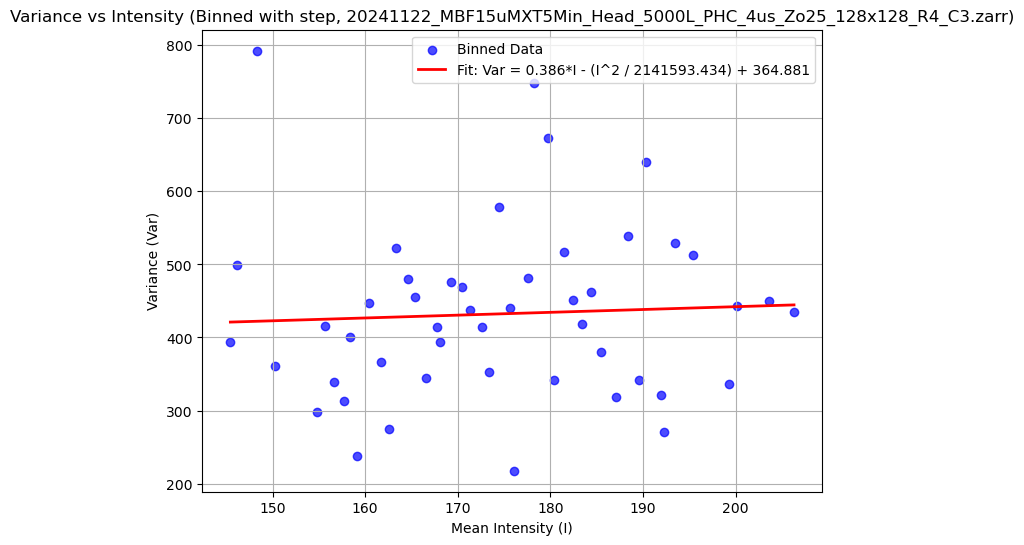

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_MBF30uMXT5Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.zarr


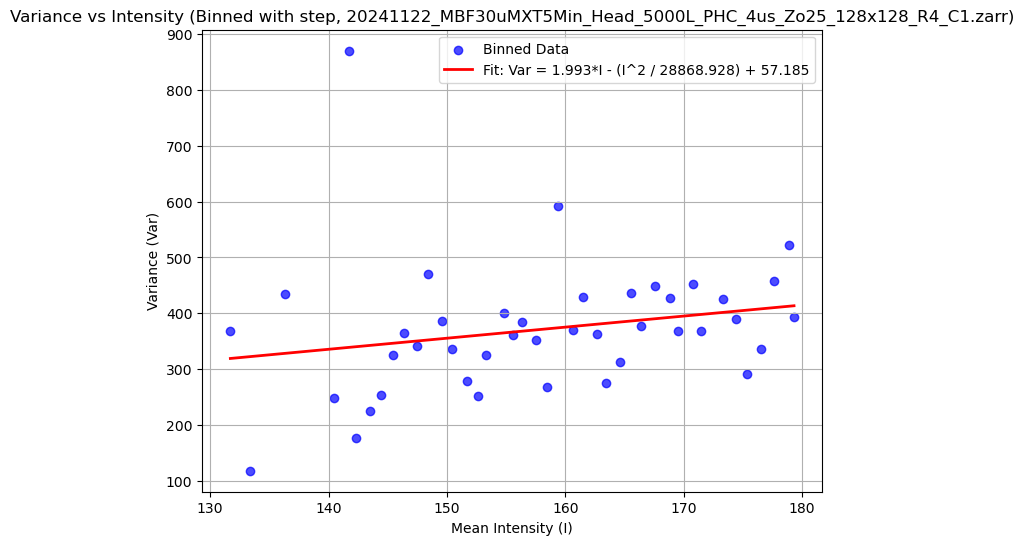

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_MBF1uMXT5Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C2.zarr


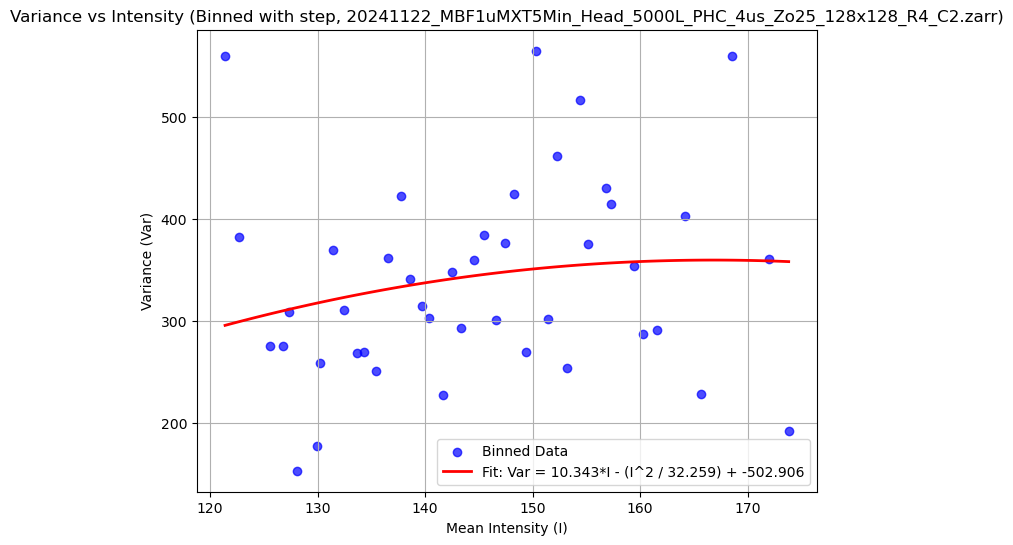

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_MBF30uMXT5Min_IONO10uM3Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.zarr


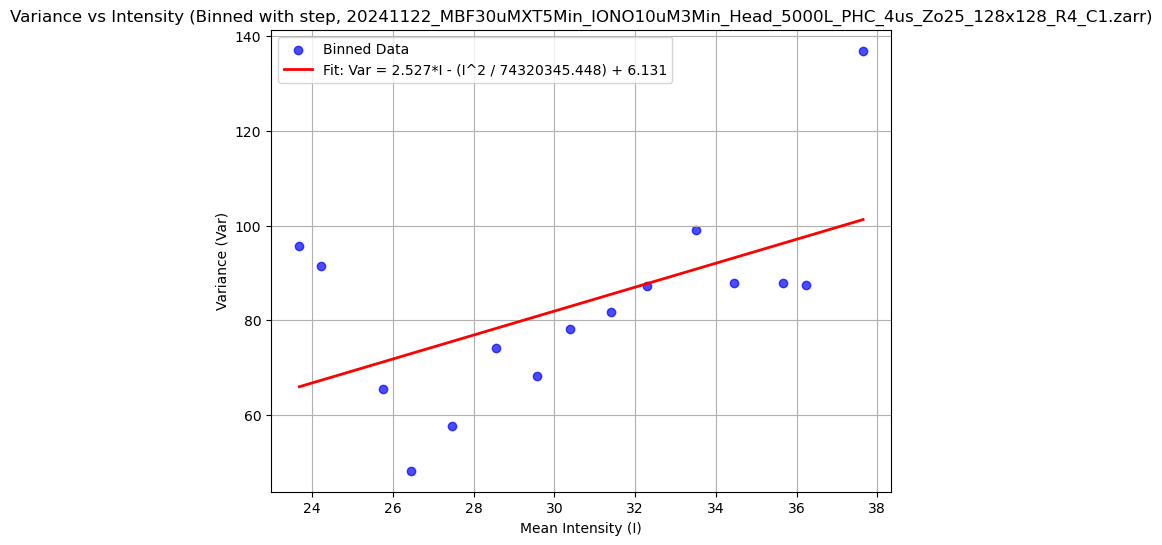

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)


In [14]:
##### Load the data list
try:
    data_list = np.load(data_file, allow_pickle=True)
    print(f"Loaded data from {data_file}.")
    
    # Access and iterate through each data_dict
    for data_dict in data_list:
        file_name = data_dict["file_name"]


        # Only process files ending with 'C2.zarr'
       # if not (file_name.endswith("C4.zarr")): # and "PHC" in file_name):
       #     continue
        if not ("PHC" in file_name and "M" in file_name and not file_name.endswith("C4.zarr")):
            continue
        
        region_result = data_dict["region_result"]
        nsna_image = data_dict["nsna_image"]
        
        print(f"File: {file_name}")
        means = np.array(region_result["mean_values"])
        variances = np.array(region_result["variance_values"])
        
       # plt.plot(means)


        
        fit_and_plot_variance_with_background_binned_step(
            means, variances, file_name, I_step, Var_step
            )

        print(f"Region Result Keys: {region_result.keys()}")
        print(f"nsna_image Shape: {nsna_image.shape}")
except Exception as e:
    print(f"Error loading file: {e}")